In [303]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from scipy.special import logsumexp
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score


# # read data

# In[2]:


X_df = pd.read_csv("mixture1.geno", header = None)
Xnew_df = pd.read_csv("mixture2.geno", header = None)
F_df = pd.read_csv("mixture1.freq", header = None) #true frequency matrix. 
Z_df = pd.read_csv("mixture1.ganc", header = None) #exact frequency. 



#print(Z_df) #for individuals
#print(X_df)
#print(F_df) #true frequency for each SP

In [46]:
#part a

def pi_mle(Z_data):
    N = Z_data.shape[0]  # Number of individuals
    pi_estimation = np.sum(Z_data, axis=0) / N #summation 
    return(pi_estimation)

print(pi_mle(Z_df)) 

0    0.394
1    0.606
dtype: float64


In [52]:
#do we take the soft ancestry assignment matrix to be the Z_data matrix??


def Freq_mat_update(Z_data, SNP_data):
    N, M = SNP_data.shape #N will be the number of individuals and M will be the number of SNPS. 
    K = Z_data.shape[1] #this will be the number of possible populations
    F = np.zeros((M, K)) #create a matrix of the proper dimensions and fill it with zeros. 
    
    for k in range(K):
        r_k = Z_data.iloc[:, k] #take each column of the true ancestry data matrix which is a column vector.
        for j in range(M):
            F[j, k] = np.dot(r_k, SNP_data.iloc[:, j]) / np.sum(r_k)
    
    return F

#print(Freq_mat_update(Z_df, X_df))
#print(F_df)

#this si similar to the ground truth matrix.


In [140]:
# # implementation M: just adjusting code from above. 

# In[3]:

#X: N by M data matrix
#gamma: P(Z_i=k | X_i=x_i, theta) N by K #we are given the ground truth matrix here. so a bunch of ones and zeros 
#gamma is probably r. 
#take the gamma function and these are the ri's? 
#is gama currently the Z_i
#part b


def M_step(X, gamma): 
    N, M = X.shape
    K = gamma.shape[1]
    
    ######### TODO 3a: modify the following to have meaning updates #########
    pis = np.sum(gamma, axis=0) / N #summation for pis 
    
    
    F = np.zeros((M, K)) #create a matrix of the proper dimensions and fill it with zeros. 
    
    for k in range(K):
        r_k = gamma.iloc[:, k] #take each column of the true ancestry data matrix which is a column vector.
        for j in range(M):
            F[j, k] = np.dot(r_k, X.iloc[:, j]) / np.sum(r_k)
    
    
    
    
    ######### end of modification #########     
    return ({"pis": pis, "F": F})


#EM is iterating and ths is asking if E step is perfect (somehow), does the M step give decent estimate on theta? 
#This is the algorithms' upper bound! 
#this would be spot on if we had an unlimited amount of data.                          

#this is done. 
pis_MLE = M_step(X_df, Z_df)["pis"]

In [158]:

# # implementation E

# In[4]:

#X: N by M data matrix
#params: a dictionary with two parameters returned from M_step
def E_step(X, params, thr = 10**(-8)): #set a limit or something
    
    F = params["F"] #Frequency matrix F: M by K
    
    F[F<thr] = thr
    
    pis = params["pis"] #Proportion vector pi: length K
    
    #the last float thing in pis is not actually returned it's just printed by sum 

    N, M = X.shape #number of individuals, number of snps 
    K = F.shape[1] #number of populations

    ######### TODO 3b: modify the following to have meaning updates #########
    
    
    #calculate weighted_log_prob: log(P(X_i=x_i | Z_i=k, theta) * P(Z_i=k | theta))
    weighted_log_prob = np.zeros((N, K))
    
    #does the arrangement of the inner and outer for loop matter, or would that just make us fill in the matrix in a different order? 
    #250 different SNPS. 
    for k in range(K):
        for i in range(N):
            log_likelihood = np.dot(X.iloc[i,:],np.log(F[:, k])) + np.dot((1 - X.iloc[i,:]),np.log(1 - F[:, k]))
            weighted_log_prob[i, k] = log_likelihood + np.log(pis[k])


    #calcualte log_prob_sample: log P(Xi=x_i | theta) length N vector. Hint: use logsumexp function
    
    log_prob_sample = logsumexp(weighted_log_prob, axis=1) #produces a vectorof size n. need to do this o the x axis. 
    
    
    #calcualte log_prob_data: log P(X_1:n=x_1:n | theta) scalar #produces a scalar 
    
    log_prob_data = np.sum(log_prob_sample) 
    
    
    #calculate log_gammas: log P(Z_i=k | X_i=x_i, theta) N by K

    log_gammas = weighted_log_prob - log_prob_sample[:, np.newaxis]
    
    ######### end of modification #########
    return log_gammas, log_prob_data

#added the thresholding step. 

In [159]:
log_gammas, _ = E_step(X_df, {"F": F_df.values, "pis": pis_MLE  })


map_estimates = np.argmax(log_gammas, axis= 1)
accuracy = adjusted_rand_score(np.argmax(Z_df.values, axis = 1), map_estimates)
print(accuracy)

#this gets a 1.0 accuracy. IDFK if that's right!
#accuracy is 1

1.0


In [308]:
#part C 
#EM implementation 

def EM(X, K = 2, max_iter = 100, tol = 10**(-4), n_init = 3, debug = False, withpis = False):
    
    N, M = X.shape 
    res = {}
    best_log_prob_data = -np.inf
    converged  = False 

    #loop through different random starting points
    
    likelihoods_total  = []
    gammas_final = []
    pis_final = []
    for init in range(1, 1+n_init, 1): #loop for the generation of random variables. 
        np.random.seed(init)
        if(debug):
            print(f"starting EM on random initialization: {init} out of {n_init}")
        
        ######### TODO 3c: modify the following to have the full EM updates #########
    
        
        # Initialize soft assignments matrix
        gammas = np.random.uniform(0.01, 0.99, size=(N, K))
    
        # Normalize across ancestry groups for each sample (so that total = 1)
        gammas = gammas / np.sum(gammas, axis=1)[:, np.newaxis]
        
        gammas = pd.DataFrame(gammas)
        
    
        #randomly initized gammas, so need to start with the M step 
        likelihoods_temp = []
        
        log_prob_data  = -np.inf
        
        for n_iter in range(1, 1+max_iter, 1):
            prev_log_prob_data = log_prob_data
            
            #need to perform M step first
            
            M_results = M_step(X, gammas) #need to update gammas
            
            
            E_results = E_step(X, M_results)
            
            log_prob_data = E_results[1]
            
            #possible it has something to do with the gammas calculation, need to take them out of log space?
            
            gammas = pd.DataFrame(np.exp(E_results[0]))
            
            likelihoods_temp.append(log_prob_data)
        
            ######### convergence check #########
            change = (log_prob_data - prev_log_prob_data)/N
            if abs(change) < tol:
                if(debug):
                    print(f"random initialization {init} converged at iteration {n_iter}")
                    print("")
                converged = True
                break
        
        if withpis:
            pis_final.append(M_results['pis'])
                
        likelihoods_total.append(likelihoods_temp)
        gammas_final.append(gammas)

        
        ######### update on the best initialization #########
        if log_prob_data > best_log_prob_data:
            best_log_prob_data = log_prob_data
            best_init = init
        
    ######### end of modification #########
    res["converged"] = converged     
    res["best_init"] = best_init
    if withpis:
        return(res, likelihoods_total, gammas_final, pis_final)
    else:
        return(res, likelihoods_total, gammas_final)

#this could be less hacky 

In [236]:
#make dataframe with only the first 10 snps 


X_df_10 = X_df.iloc[:, 0:10]
print(X_df_10)


#then I will train the model on only the first 10 snps 

     0  1  2  3  4  5  6  7  8  9
0    0  0  1  1  0  0  1  1  0  0
1    0  0  0  0  1  0  1  0  1  1
2    0  0  1  0  1  0  0  1  1  0
3    1  0  0  0  0  0  1  1  0  0
4    0  0  1  0  0  0  0  0  1  0
..  .. .. .. .. .. .. .. .. .. ..
995  1  1  0  0  0  1  0  1  0  0
996  1  1  0  0  0  1  0  1  0  0
997  0  0  1  0  0  0  0  1  1  0
998  0  0  1  0  0  0  0  0  1  1
999  0  0  1  0  0  0  0  0  1  0

[1000 rows x 10 columns]


In [315]:
results = EM(X_df_10)

#part d

({'converged': True, 'best_init': 2}, [[-6172.184588445144, -6171.539624603998, -6168.560741628349, -6155.00360933936, -6102.760378657513, -5981.8658426869115, -5873.250108284283, -5836.195122219589, -5826.500137053043, -5823.457747590119, -5822.442014447912, -5822.09243203611, -5821.960101566911, -5821.899981369479], [-6172.349444973524, -6171.721286086776, -6169.211510327037, -6157.837512904648, -6112.697161164216, -5998.997348076617, -5882.511341618853, -5838.725362627847, -5827.291316469098, -5823.720795092191, -5822.519581505028, -5822.108448354256, -5821.957730693033, -5821.893146436643], [-6172.50915589875, -6172.2082368906595, -6171.509282812525, -6168.3593224300785, -6154.079460917732, -6099.618381426115, -5976.755501303345, -5870.400109415542, -5835.2263322654535, -5826.15871777433, -5823.349121708954, -5822.418017176311, -5822.095352896014, -5821.96975946659, -5821.910103480436]], [            0         1
0    0.017736  0.982264
1    0.013797  0.986203
2    0.002550  0.99745

In [316]:
print(results[1])

[[-6172.184588445144, -6171.539624603998, -6168.560741628349, -6155.00360933936, -6102.760378657513, -5981.8658426869115, -5873.250108284283, -5836.195122219589, -5826.500137053043, -5823.457747590119, -5822.442014447912, -5822.09243203611, -5821.960101566911, -5821.899981369479], [-6172.349444973524, -6171.721286086776, -6169.211510327037, -6157.837512904648, -6112.697161164216, -5998.997348076617, -5882.511341618853, -5838.725362627847, -5827.291316469098, -5823.720795092191, -5822.519581505028, -5822.108448354256, -5821.957730693033, -5821.893146436643], [-6172.50915589875, -6172.2082368906595, -6171.509282812525, -6168.3593224300785, -6154.079460917732, -6099.618381426115, -5976.755501303345, -5870.400109415542, -5835.2263322654535, -5826.15871777433, -5823.349121708954, -5822.418017176311, -5822.095352896014, -5821.96975946659, -5821.910103480436]]


Text(0, 0.5, 'log likelihood')

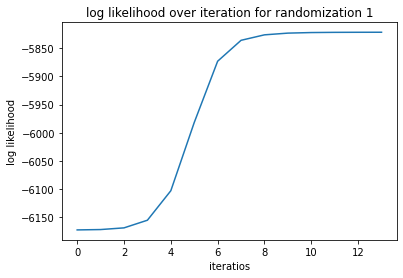

In [366]:
#graphs to submit for part c 
results[1][0]

iterations = range(len(results[1][0]))

plt.plot(iterations, results[1][0])
plt.title("log likelihood over iteration for randomization 1")
plt.xlabel("iteratios")
plt.ylabel("log likelihood")

Text(0, 0.5, 'log likelihood')

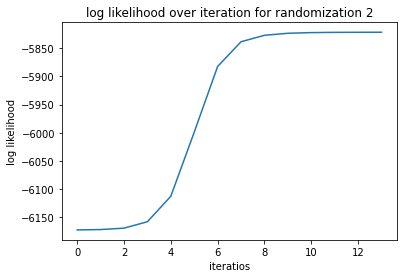

In [367]:
results[1][1]

iterations2 = range(len(results[1][1]))

plt.plot(iterations2, results[1][1])
plt.title("log likelihood over iteration for randomization 2")
plt.xlabel("iteratios")
plt.ylabel("log likelihood")

[-6172.50915589875, -6172.2082368906595, -6171.509282812525, -6168.3593224300785, -6154.079460917732, -6099.618381426115, -5976.755501303345, -5870.400109415542, -5835.2263322654535, -5826.15871777433, -5823.349121708954, -5822.418017176311, -5822.095352896014, -5821.96975946659, -5821.910103480436]


Text(0, 0.5, 'log likelihood')

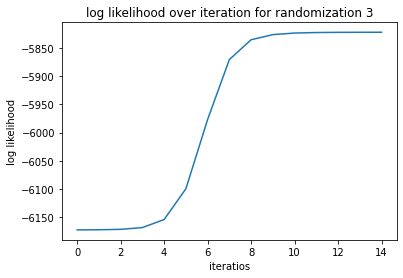

In [368]:
print(results[1][2])

iterations3 = range(len(results[1][2]))

plt.plot(iterations3, results[1][2])
plt.title("log likelihood over iteration for randomization 3")
plt.xlabel("iteratios")
plt.ylabel("log likelihood")

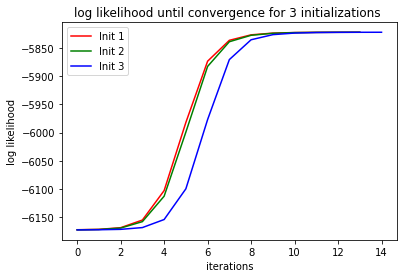

In [384]:
plt.plot(iterations, results[1][0], color = "red", label = "Init 1")
plt.plot(iterations2, results[1][1], color = "green", label = "Init 2")
plt.plot(iterations3, results[1][2], color = "blue", label = "Init 3")
plt.title("log likelihood until convergence for 3 initializations ")
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.legend()
plt.savefig("log_likelihoods_3ters.png", dpi = 300)

In [248]:
results_d = EM(X_df_10, K = 3)

In [382]:
print(np.max(results_d[1][0]))
print(np.max(results_d[1][1]))
print(np.max(results_d[1][2]))

#for the 3rd trial: -5812.61020776288
#for the 2nd trial: -6172.342222665949
#for the 1st trial: -5814.294174285431

-5814.294174285431
-6172.342222665949
-5812.61020776288


In [354]:
#part e

results_e = EM(X_df_10, K = 3)

[-6172.404845216184, -6172.342222665949]


In [372]:
gammas_1 = np.array(results_e[2][0])

ancestry_labels_trial_1 = np.argmax(gammas_1, axis= 1)

gammas_2 = np.array(results_e[2][1])

ancestry_labels_trial_2 = np.argmax(gammas_2, axis= 1)

gammas_3 = np.array(results_e[2][2])

ancestry_labels_trial_3 = np.argmax(gammas_3, axis= 1)



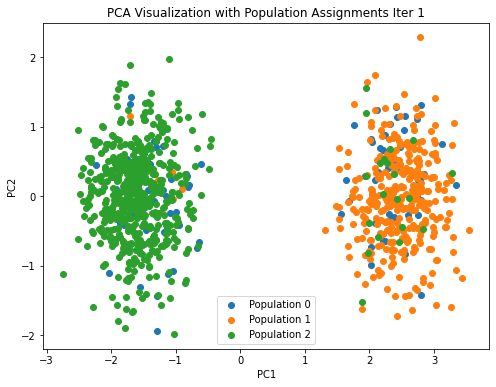

In [392]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


#for this idk whether to use the whole data or just the first 10 snps ASDRFTGHJ,
np.random.seed(0)

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
transformed_data = pca.fit_transform(X_df.values)

plt.figure(figsize=(8, 6))

# Loop through unique population assignments
for population_id in np.unique(ancestry_labels_trial_1):
    # Select indices for each population
    indices = np.where(ancestry_labels_trial_1 == population_id)
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Population {population_id}')

# Set labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization with Population Assignments Iter 1')
plt.legend()
plt.savefig("iter_1_cluster.png", dpi = 300)


#somehow asign colors. 
#plt.figure(figsize=(8, 6))
#unique_populations = set(population_labels)
#colors = ['blue', 'green', 'red', "purple"]  # Define colors for different populations

#for i, pop_label in enumerate(unique_populations):
#    mask = (population_labels == pop_label)
#    plt.scatter(transformed_data[mask, 0], transformed_data[mask, 1], label=pop_label, color=colors[i])

#plt.title('PCA Visualization with Population Coloring')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.legend()
#plt.grid(True)

#plt.savefig('pca_plot_high_res.png', dpi=300)  # Change file format if needed (e.g., '.pdf', '.svg')

#plt.show()

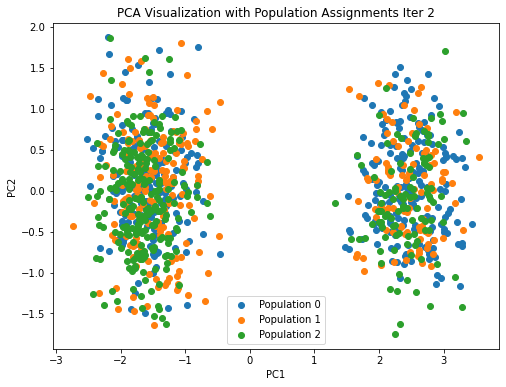

In [393]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#np.random.seed(0)

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
transformed_data = pca.fit_transform(X_df.values)

plt.figure(figsize=(8, 6))

# Loop through unique population assignments
for population_id in np.unique(ancestry_labels_trial_2):
    # Select indices for each population
    indices = np.where(ancestry_labels_trial_2 == population_id)
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Population {population_id}')

# Set labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization with Population Assignments Iter 2')
plt.legend()
plt.savefig("iter_2_cluster.png", dpi = 300)

#somehow asign colors. 
#plt.figure(figsize=(8, 6))
#unique_populations = set(population_labels)
#colors = ['blue', 'green', 'red', "purple"]  # Define colors for different populations

#for i, pop_label in enumerate(unique_populations):
#    mask = (population_labels == pop_label)
#    plt.scatter(transformed_data[mask, 0], transformed_data[mask, 1], label=pop_label, color=colors[i])

#plt.title('PCA Visualization with Population Coloring')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.legend()
#plt.grid(True)

#plt.savefig('pca_plot_high_res.png', dpi=300)  # Change file format if needed (e.g., '.pdf', '.svg')

#plt.show()

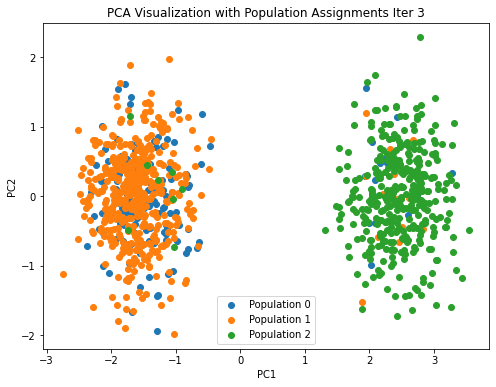

In [394]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

np.random.seed(0)

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
transformed_data = pca.fit_transform(X_df.values)

plt.figure(figsize=(8, 6))

# Loop through unique population assignments
for population_id in np.unique(ancestry_labels_trial_3):
    # Select indices for each population
    indices = np.where(ancestry_labels_trial_3 == population_id)
    plt.scatter(transformed_data[indices, 0], transformed_data[indices, 1], label=f'Population {population_id}')

# Set labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization with Population Assignments Iter 3')
plt.legend()
plt.savefig("iter_3_cluster.png", dpi = 300)



#somehow asign colors. 
#plt.figure(figsize=(8, 6))
#unique_populations = set(population_labels)
#colors = ['blue', 'green', 'red', "purple"]  # Define colors for different populations

#for i, pop_label in enumerate(unique_populations):
#    mask = (population_labels == pop_label)
#    plt.scatter(transformed_data[mask, 0], transformed_data[mask, 1], label=pop_label, color=colors[i])

#plt.title('PCA Visualization with Population Coloring')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.legend()
#plt.grid(True)

#plt.savefig('pca_plot_high_res.png', dpi=300)  # Change file format if needed (e.g., '.pdf', '.svg')

#plt.show()

In [286]:
#part f: adjusted rand score 

#set k = 2

sizes = [10, 25, 50, 100, 150, 200, 250]


rand_scores = []
for i in sizes:
    x_df_temp = X_df.iloc[:, 0:i]
    results_temp = EM(x_df_temp, K = 2)
    best_init_index = results_temp[0]['best_init']-1
    gammas_temp_best = np.array(results_temp[2][best_init_index])
    ancestry_labels_temp = np.argmax(gammas_temp_best, axis= 1)
    accuracy_temp = adjusted_rand_score(np.argmax(Z_df.values, axis = 1), ancestry_labels_temp)
    rand_scores.append(accuracy_temp)
    
    
    

[0.8681858998256261, 0.9446215746273722, 0.9760720170761824, 0.995992394446082, 1.0, 1.0, 1.0]


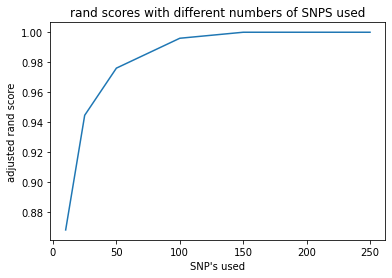

In [396]:
print(rand_scores)

plt.plot(sizes, rand_scores)
plt.title("rand scores with different numbers of SNPS used")
plt.xlabel("SNP's used")
plt.ylabel("adjusted rand score")
plt.savefig("rand.png", dpi = 300)


In [313]:
#part g. not sure, ask johnson. 
ks = [1,2,3,4,5]
x_df_g = X_df.iloc[:, 0:100]


likelihood_scores = []
for i in ks :
    results_temp = EM(x_df_g, K = i )
    best_init_index = results_temp[0]['best_init']-1
    array_log_likelihood = results_temp[1][best_init_index]
    max_temp_likelihood = max(array_log_likelihood)
    likelihood_scores.append(max_temp_likelihood)

/var/folders/y2/xc9jb_w133n8tymks1sbxh7m0000gp/T/ipykernel_20322/2193699901.py:30: RuntimeWarning: invalid value encountered in log
  log_likelihood = np.dot(X.iloc[i,:],np.log(F[:, k])) + np.dot((1 - X.iloc[i,:]),np.log(1 - F[:, k]))
/var/folders/y2/xc9jb_w133n8tymks1sbxh7m0000gp/T/ipykernel_20322/2193699901.py:31: RuntimeWarning: divide by zero encountered in log
  weighted_log_prob[i, k] = log_likelihood + np.log(pis[k])
/var/folders/y2/xc9jb_w133n8tymks1sbxh7m0000gp/T/ipykernel_20322/2193699901.py:30: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.dot(X.iloc[i,:],np.log(F[:, k])) + np.dot((1 - X.iloc[i,:]),np.log(1 - F[:, k]))


[-56328.319681910376, -51745.86130733159, -51641.9945200589, -51587.90022822253, -51475.86920885707]


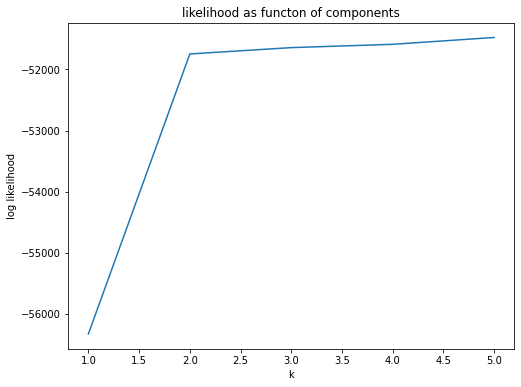

In [406]:
print(likelihood_scores)
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

plt.plot(ks, likelihood_scores)
plt.xlabel("k")
plt.title("likelihood as functon of components")
plt.ylabel("log likelihood")

plt.savefig("components", dpi = 100)

#MARGINAL benefit is dropping sfter 2 clusters 

In [309]:
#part h

#for dataset 2: run EM with k = 2 and report final pi value. 

EM_datset_2 = EM(Xnew_df, K = 2, withpis = True)


In [310]:
print(EM_datset_2[3])

#not sure if this means for the pi values 

#all runs produce the same pis final somehow. 

[0    0.224
1    0.776
dtype: float64, 0    0.776
1    0.224
dtype: float64, 0    0.224
1    0.776
dtype: float64]


In [312]:
#given the run EM_dataset_2

#step 1: make hard assignments: 

best_init_index = EM_datset_2[0]['best_init']-1
gammas_x2 = np.array(EM_datset_2[2][best_init_index])
#ancestry_labels_x2 = np.argmax(gammas_x2, axis= 1)

pi_mle(gammas_x2)

#this produices the same results. 

array([0.224, 0.776])